Focused vector-beams
=================================

*Example author: Arnaud Arbouet (Vectorbeam implementation by A. Arbouet with contributions from Y. Brûlé and G. Colas des Francs)*

In this example, we show fields around the focal position of several vector beams and reproduce the scattering spectra from silicon nanospheres under vectorbeam illumination reported by Manna et al. [1].

[1] Manna et al. *Selective excitation and enhancement of multipolar resonances in dielectric nanospheres using cylindrical vector beams*. **Journal of Applied Physics** 127, 033101 (2020).
 (http://dx.doi.org/10.1016/j.optcom.2019.124336)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyGDM2 import structures
from pyGDM2 import fields
from pyGDM2 import tools
from pyGDM2 import visu
from pyGDM2 import core
from pyGDM2 import materials
from pyGDM2 import propagators
from pyGDM2 import linear


/home/hans/.local/lib/python3.8/site-packages/numba/core/cpu.py:97: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'VersionConflict((scipy 1.7.1 (/home/hans/.local/lib/python3.8/site-packages), Requirement.parse('scipy<=1.6.2,>=0.16')))'.
  numba.core.entrypoints.init_all()


plot incident fields
------------------------------

For a first demonstration we plot the incident fields around the focal spot in the XY and XZ plane.

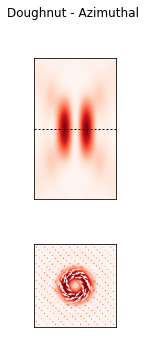

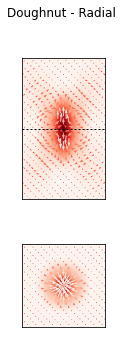

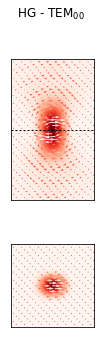

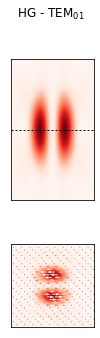

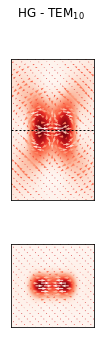

In [2]:
## --- define 2D evaluation plane
side = 600
Npt = 31
y_factor_side = 1.7
r_probe_XY = tools.generate_NF_map(-side,side,Npt, -side,side,Npt,  Z0=0, projection='XY')
r_probe_XZ = tools.generate_NF_map(-side,side,Npt, -1*y_factor_side*side, y_factor_side*side, int(y_factor_side*Npt),  Z0=0, projection='XZ')

## -- different beams to evaluate
field_gen_configs = [
        [fields.focused_beams.Azimuth_pol_doughnut, 'Doughnut - Azimuthal'],
        [fields.focused_beams.Radial_pol_doughnut, 'Doughnut - Radial'],
        [fields.focused_beams.HermiteGauss00, r'HG - TEM$_{00}$'],
        [fields.focused_beams.HermiteGauss01, r'HG - TEM$_{01}$'],
        [fields.focused_beams.HermiteGauss10, r'HG - TEM$_{10}$'],
    ]

## --- further field generator config.
wavelength = 600

n1 = n2 = n3 = 1.518    # homogeneous
spacing = 100000.0      # thickness of layer n2 (in nm)
env_dict = dict(eps1=n1**2, eps2=n2**2, eps3=n3**2, spacing=spacing)

NA = 1.4   # focusing numerical aperture
f = 100    # lens focal distance (mm)
f0 = 1     # filling factor
w0 = f0*f*NA/n2

kwargs = dict(xSpot=0.0, ySpot=0.0, zSpot=0.0, kSign = -1.0,
              NA = NA, f = f, w0 = w0, returnField='E')


## --- evaluate and plot all fields
results_XZ = []
results_XY = []
for i, field_conf in enumerate(field_gen_configs):
    field_generator = field_conf[0]
    plot_title = field_conf[1]
    
    ## --- evaluation of the field-generator
    NF_XY = field_generator(r_probe_XY, env_dict, wavelength,**kwargs)
    NF_XZ = field_generator(r_probe_XZ, env_dict, wavelength,**kwargs)

    Nskipvec = 3  # show fewer vectors than evaluated
    plt.figure(figsize=(1.5, 5))
    plt.suptitle(plot_title)
    
    
    ## ============ XZ plane
    ## plot the field intensity
    plt.subplot2grid((5,1),(0,0), aspect='equal', rowspan=3)
    v = visu.vectorfield_color(NF_XZ, r_probe_XZ, projection='XZ', tit='', 
                               show=0, cmap=plt.cm.Reds, interpolation='bicubic')
    
    ## skip plotting field vectors if XZ components are zero
    if plot_title not in ['Doughnut - Azimuthal', 'HG - TEM$_{01}$']:
        v = visu.vectorfield(NF_XZ[::Nskipvec], r_probe_XZ[::Nskipvec], complex_part='real', projection='XZ', 
                             tit='', show=0, cmap=plt.cm.Reds_r, scale=8, vecwidth=2.25, rasterized=True)
    
    plt.axhline(0, color='k', dashes=[2,2], lw=1)
    plt.xticks([]); plt.yticks([])
    plt.xlabel(''); plt.ylabel('')
    plt.xlim(-side, side)
    plt.ylim(-1*y_factor_side*side, y_factor_side*side)

    
    ## ============ XY plane
    plt.subplot2grid((5,1),(3,0), aspect='equal', rowspan=2)
    ## plot the field intensity
    v = visu.vectorfield_color(NF_XY, r_probe_XY, projection='XY', tit='', 
                               show=0, cmap=plt.cm.Reds, interpolation='bicubic')
    ## plot the field vectors
    v = visu.vectorfield(NF_XY[::Nskipvec], r_probe_XY[::Nskipvec], complex_part='real', projection='XY', 
                         tit='', show=0, cmap=plt.cm.Reds_r, scale=9.5, vecwidth=2.25, rasterized=True)
    
    plt.xticks([]); plt.yticks([])
    plt.xlabel(''); plt.ylabel('')
    plt.xlim(-side, side)
    plt.ylim(-side, side)
    
    
    plt.tight_layout(h_pad=0)
    plt.show()    

Simulation with vector beam illumination
----------------------------------------------------------

Now let's reproduce and simulate the configuration of [1] with pyGDM.

In [3]:
## --- structure definition: Si nano-sphere
mesh = 'hex'
radius = 170/2. # nm 
step = 17.5     # nm; a smaller step was used for the paper figure

geometry = structures.sphere(step, R = radius/step, mesh=mesh)
material = materials.silicon()
struct = structures.struct(step, geometry, material, normalization=mesh)

print(" N dipoles:", len(struct.geometry))


## --- environment (--> homogenous, oil)
n1 = n2 = n3 = 1.48
spacing = 10000.
dyads = propagators.DyadsQuasistatic123(n1, n2, n3, spacing=spacing)


## --- illumination
NA = 1.2
f = 100     # focal length (mm)
w0 = f * NA / n2   # n2: structure environment

wavelengths =np.linspace(400,800,31)  # finer spectra were calcualted for the paper

## LINEAR polarization beam
field_generator_LIN = fields.HermiteGauss00
kwargs_LIN = dict(xSpot=0.0, ySpot=0.0, zSpot=0.0, kSign=-1.0,
                  NA=NA, f=f, w0=w0)

efield_LIN = fields.efield(field_generator_LIN, 
                           wavelengths=wavelengths, 
                           kwargs=kwargs_LIN)


## AZIMUTHAL beam
field_generator_AZI = fields.Azimuth_pol_doughnut
kwargs_AZI = dict(xSpot=0.0, ySpot=0.0, zSpot=0.0, kSign=-1.0,
                  NA=NA, f=f, w0=w0)

efield_AZI = fields.efield(field_generator_AZI, 
                           wavelengths=wavelengths, 
                           kwargs=kwargs_AZI)


## RADIAL beam
field_generator_RAD = fields.Radial_pol_doughnut
kwargs_RAD = dict(xSpot=0.0, ySpot=0.0, zSpot=0.0, kSign=-1.0,
                  NA=NA, f=f, w0=w0)

efield_RAD = fields.efield(field_generator_RAD, 
                           wavelengths=wavelengths,
                           kwargs=kwargs_RAD)


## --- Simulation Initialization
sim_LIN = core.simulation(struct=struct, efield=efield_LIN, dyads=dyads)
sim_AZI = core.simulation(struct=struct, efield=efield_AZI, dyads=dyads)
sim_RAD = core.simulation(struct=struct, efield=efield_RAD, dyads=dyads)



#============================================================================
# Run the simulations and compute the cross sections
#==============================================================================

## COMPUTATION WITH LINEAR BEAM
sim_LIN.scatter()
extinct = linear.extinct(sim_LIN, 0)

field_kwargs = tools.get_possible_field_params_spectra(sim_LIN)[0]  # first config (of 1)
wl_LIN, extinc_LIN = tools.calculate_spectrum(sim_LIN, field_kwargs, linear.extinct)


## COMPUTATION WITH AZIMUTHAL BEAM
sim_AZI.scatter()
extinct = linear.extinct(sim_AZI, 0)

field_kwargs = tools.get_possible_field_params_spectra(sim_AZI)[0]  # first config (of 1)
wl_AZI, extinc_AZI = tools.calculate_spectrum(sim_AZI, field_kwargs, linear.extinct)


## COMPUTATION WITH RADIAL BEAM
sim_RAD.scatter()
extinct = linear.extinct(sim_RAD, 0)

field_kwargs = tools.get_possible_field_params_spectra(sim_RAD)[0]  # first config (of 1)
wl_RAD, extinc_RAD = tools.calculate_spectrum(sim_RAD, field_kwargs, linear.extinct)


structure initialization - consistency check: 763/763 dipoles valid
 N dipoles: 763
timing for wl=400.00nm - setup: EE 5370.8ms, inv.: 177.8ms, repropa.: 1827.9ms (1 field configs), tot: 7376.7ms
timing for wl=413.33nm - setup: EE 42.0ms, inv.: 161.4ms, repropa.: 1488.1ms (1 field configs), tot: 1692.1ms
timing for wl=426.67nm - setup: EE 40.8ms, inv.: 155.1ms, repropa.: 1459.0ms (1 field configs), tot: 1655.4ms
timing for wl=440.00nm - setup: EE 42.2ms, inv.: 155.4ms, repropa.: 1458.8ms (1 field configs), tot: 1656.8ms
timing for wl=453.33nm - setup: EE 42.1ms, inv.: 164.1ms, repropa.: 1474.0ms (1 field configs), tot: 1680.7ms
timing for wl=466.67nm - setup: EE 41.9ms, inv.: 158.0ms, repropa.: 1475.3ms (1 field configs), tot: 1676.2ms
timing for wl=480.00nm - setup: EE 41.7ms, inv.: 157.0ms, repropa.: 1472.3ms (1 field configs), tot: 1671.5ms
timing for wl=493.33nm - setup: EE 41.0ms, inv.: 160.4ms, repropa.: 1477.3ms (1 field configs), tot: 1679.6ms
timing for wl=506.67nm - setup: EE

timing for wl=560.00nm - setup: EE 42.2ms, inv.: 156.9ms, repropa.: 1483.6ms (1 field configs), tot: 1683.2ms
timing for wl=573.33nm - setup: EE 40.6ms, inv.: 160.6ms, repropa.: 1490.1ms (1 field configs), tot: 1692.2ms
timing for wl=586.67nm - setup: EE 40.8ms, inv.: 153.0ms, repropa.: 1474.9ms (1 field configs), tot: 1669.3ms
timing for wl=600.00nm - setup: EE 41.9ms, inv.: 153.3ms, repropa.: 1477.5ms (1 field configs), tot: 1673.2ms
timing for wl=613.33nm - setup: EE 43.7ms, inv.: 154.6ms, repropa.: 1474.0ms (1 field configs), tot: 1672.8ms
timing for wl=626.67nm - setup: EE 40.8ms, inv.: 186.0ms, repropa.: 1489.1ms (1 field configs), tot: 1716.3ms
timing for wl=640.00nm - setup: EE 39.7ms, inv.: 152.8ms, repropa.: 1492.0ms (1 field configs), tot: 1685.1ms
timing for wl=653.33nm - setup: EE 41.2ms, inv.: 153.9ms, repropa.: 1488.2ms (1 field configs), tot: 1683.8ms
timing for wl=666.67nm - setup: EE 42.1ms, inv.: 154.6ms, repropa.: 1494.5ms (1 field configs), tot: 1691.6ms
timing for

Plot the nearfield intensity maps
---------------------------------------------

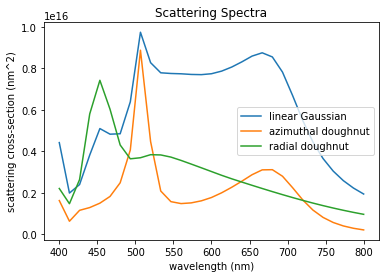

In [4]:
plt.figure()
plt.title(r"Scattering Spectra")

plt.plot(wl_LIN, extinc_LIN.T[1], label='linear Gaussian')
plt.plot(wl_AZI, extinc_AZI.T[1], label='azimuthal doughnut')
plt.plot(wl_RAD, extinc_RAD.T[1], label='radial doughnut')

plt.legend()
plt.xlabel('wavelength (nm)') 
plt.ylabel('scattering cross-section (nm^2)')

plt.show()